Importing the dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# For encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# For training the model and evaluating
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [ ]:
df=pd.read_csv('job_train.csv')
df.head()

,title,location,description,requirements,telecommuting,has_company_logo,has_questions,fraudulent
0,Architect (Middleware - MQ) - Kuwait,"KW, KU,","On behalf of our client, a well known multinat...",-Working technical knowledge of IT systems and...,0,1,0,0
1,Interviewing Now for Sales Rep Positions -- wi...,"US, TX, Corpus Christi","We are Argenta Field Solutions, a rapidly expa...",#NAME?,0,1,0,0
2,Process Controls Staff Engineer - Foxboro I/A ...,"US, TX, USA Southwest",Experienced Process Controls Staff Engineer is...,At least 10 years of degreed professional expe...,0,0,0,0
3,Experienced Telemarketer Wanted - Digital Solu...,"AU, NSW,",If you have a passion for people and love to s...,"Responsibilities - Prospecting, following up a...",0,1,0,0
4,Senior Network Engineer,"GB, ENG, London",As the successful Senior Network Engineer you ...,Essential skills:•Juniper switching/routing/se...,0,1,0,0


In [ ]:
df.shape

(8940, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8940 entries, 0 to 8939
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             8940 non-null   object
 1   location          8783 non-null   object
 2   description       8939 non-null   object
 3   requirements      7614 non-null   object
 4   telecommuting     8940 non-null   int64 
 5   has_company_logo  8940 non-null   int64 
 6   has_questions     8940 non-null   int64 
 7   fraudulent        8940 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 558.9+ KB


From above we know that,

The dataset contains 8 columns and 8,940 rows, with the following features:


*   title (object): The job title.
*   location (object): The location of the job, with some missing values.

*   description (object): The job description.

*   requirements (object): The job requirements, with some missing values.
*   telecommuting (int64): Binary indicator (0 or 1) of whether the job is remote.


*   has_company_logo (int64): Binary indicator (0 or 1) of whether the job posting includes a company logo.


*   has_questions (int64): Binary indicator (0 or 1) of whether the job posting includes screening questions.
*   fraudulent (int64): The target variable indicating if the job is fraudulent (1) or not (0).

Data Preprocessing

In [ ]:
df.isnull().sum()

,0
title,0
location,157
description,1
requirements,1326
telecommuting,0
has_company_logo,0
has_questions,0
fraudulent,0


From above we came to know that there are some missing values in the dataset.

Handling Missing Values

In [ ]:
# Filling the missing description value with an empty string
df['description'].fillna('',inplace=True)

In [ ]:
# Filling the missing location value with 'Unknown' string
df['location'].fillna('Unknown',inplace=True)

# Filling the missing requirements value with an empty string
df['requirements'].fillna('',inplace=True)

In [ ]:
df.isnull().sum()

,0
title,0
location,0
description,0
requirements,0
telecommuting,0
has_company_logo,0
has_questions,0
fraudulent,0


Now Encoding the text data

for easy text features such as 'title' and 'location' using label encoding

and for heavy text features such as 'desciption' and 'requirements' using TF-IDF (Term Frequency-Inverse Document Frequency) to  quantify the importance or relevance of string representations.

In [ ]:
df['title'].unique()

array(['Architect (Middleware - MQ) - Kuwait',
       'Interviewing Now for Sales Rep Positions -- with Management Training',
       'Process Controls Staff Engineer - Foxboro I/A TriconexSIS - TX',
       ..., 'Head of Customer Support', 'Customer Care Consultant',
       'Data Manager--Fixed Income'], dtype=object)

In [ ]:
df['title'].value_counts()

,count
title,
English Teacher Abroad,152
Customer Service Associate,82
Graduates: English Teacher Abroad (Conversational),70
English Teacher Abroad (Conversational),47
English Teacher Abroad,44
...,...
Machine Operator,1
Account Executive - Sydney,1
"Machine Builder Supervisor - Spring Lake, MI",1


In [ ]:
df['location'].unique()

array(['KW, KU, ', 'US, TX, Corpus Christi', 'US, TX, USA Southwest', ...,
       'GR, I, Paiania', 'CA, ON, Peterborough', 'UA, 61, Ternopil'],
      dtype=object)

In [ ]:
df['location'].value_counts()

,count
location,
"GB, LND, London",367
"US, NY, New York",331
"GR, I, Athens",244
"US, CA, San Francisco",241
"US, ,",180
...,...
"US, RI, West Greenwich",1
"US, SD, Rapid City",1
"US, NJ, Haddonfield",1


In [ ]:
# Initialize LabelEncoder for 'title' and 'location'
label_encoder = LabelEncoder()

# Apply Label Encoding to 'title' and 'location'
df['title_encoded'] = label_encoder.fit_transform(df['title'])
df['location_encoded'] = label_encoder.fit_transform(df['location'])

# Initialize TF-IDF Vectorizer for 'description' and 'requirements'
tfidf_vectorizer = TfidfVectorizer(max_features=500)

# Apply TF-IDF Vectorization to 'description'
description_tfidf = tfidf_vectorizer.fit_transform(df['description'])

# Apply TF-IDF Vectorization to 'requirements'
requirements_tfidf = tfidf_vectorizer.fit_transform(df['requirements'])

# Convert TF-IDF matrices to DataFrames
description_tfidf_df = pd.DataFrame(description_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
requirements_tfidf_df = pd.DataFrame(requirements_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Combine all the features into a single DataFrame
encoded_data = pd.concat([df[['telecommuting', 'has_company_logo', 'has_questions', 'title_encoded', 'location_encoded']],
                          description_tfidf_df, requirements_tfidf_df], axis=1)

# Check the first few rows of the final encoded dataset
print(encoded_data.head())

   telecommuting  has_company_logo  has_questions  title_encoded  \
0              0                 1              0            376   
1              0                 1              0           2771   
2              0                 0              0           3980   
3              0                 1              0           1844   
4              0                 1              0           4908   

   location_encoded        10   18  ability     able  about  ...      work  \
0               662  0.000000  0.0      0.0  0.00000    0.0  ...  0.000000   
1              1937  0.000000  0.0      0.0  0.00000    0.0  ...  0.000000   
2              1990  0.000000  0.0      0.0  0.08084    0.0  ...  0.053053   
3                21  0.152082  0.0      0.0  0.00000    0.0  ...  0.000000   
4               343  0.000000  0.0      0.0  0.00000    0.0  ...  0.000000   

    working  would  write  writing   written  year     years       you  \
0  0.069415    0.0    0.0      0.0  0.069063   0

Splitting the dataset

In [ ]:
# encoded_data is the final dataset after preprocessing and encoding
X = encoded_data
y = df['fraudulent']  # Target variable

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fixing Imbalanced Dataset

In [ ]:
df['fraudulent'].value_counts()

,count
fraudulent,
0,8484
1,456


as we can see that our dataset is highly imbalanced so we will be using a technique called 'SMOTE' (Synthetic Minority Over-sampling Technique) to generate synthetic example rather than duplicating existing ones.

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(X_resampled.shape, y_resampled.shape)

(13580, 1005) (13580,)


Training the model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'class_weight': ['balanced', None]
}

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_resampled, y_resampled)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 200}
Best Score: 0.9997852685552913


In [ ]:
# Initialize the RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', max_depth=None, n_estimators=200, random_state=42)

# Train the model on the training data
model.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

Evaluating the model

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1694
           1       1.00      0.39      0.56        94

    accuracy                           0.97      1788
   macro avg       0.98      0.70      0.77      1788
weighted avg       0.97      0.97      0.96      1788

Confusion Matrix:
 [[1694    0]
 [  57   37]]
ROC-AUC Score: 0.9349581752869954


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='roc_auc')

print("Cross-Validation Scores:", scores)
print("Mean ROC-AUC Score:", scores.mean())
print("Standard Deviation:", scores.std())

Cross-Validation Scores: [0.9998056  0.9999775  0.99990456 0.99976683 0.99981536]
Mean ROC-AUC Score: 0.9998539717725755
Standard Deviation: 7.647405863925084e-05


In [ ]:
scores1 = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='f1')

print("Cross-Validation Scores(F1):", scores1)
print("Mean F1 Score:", scores1.mean())
print("Standard Deviation:", scores1.std())

Cross-Validation Scores(F1): [0.99556541 0.99630724 0.99519409 0.99667774 0.99593346]
Mean F1 Score: 0.9959355860933755
Standard Deviation: 0.0005245526212364711


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = model.predict(X_test)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1694
           1       1.00      0.39      0.56        94

    accuracy                           0.97      1788
   macro avg       0.98      0.70      0.77      1788
weighted avg       0.97      0.97      0.96      1788

Confusion Matrix:
 [[1694    0]
 [  57   37]]


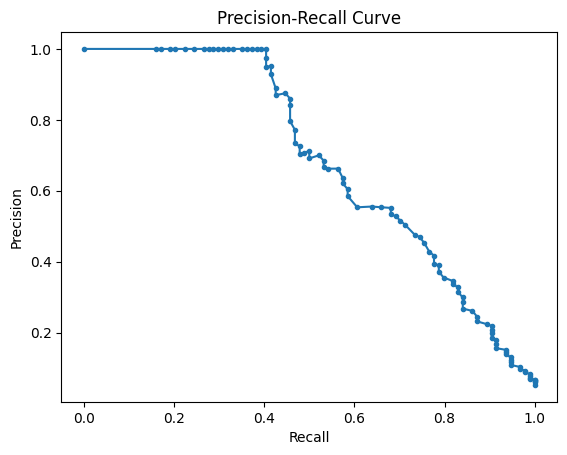

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


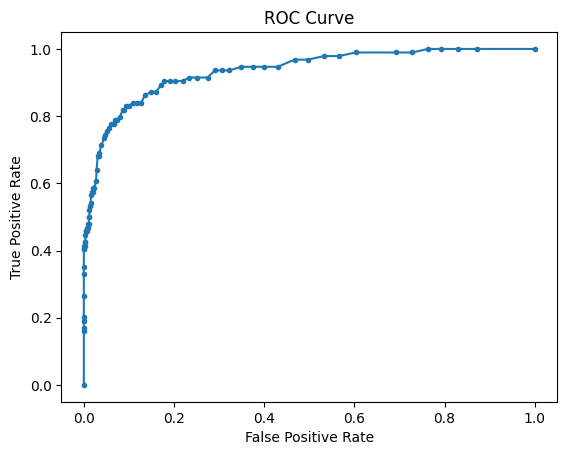

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_scores)

plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


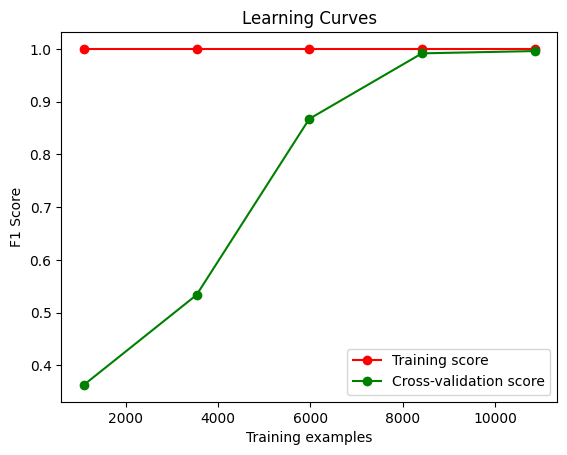

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(model, X_resampled, y_resampled, cv=cv, scoring='f1')

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.title('Learning Curves')
plt.show()
